# Functional Renormalization Group for Signal Detection

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import re
import matplotlib as mpl
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pathlib import Path
from typing import Any

from frg import MarchenkoPastur, EmpiricalDistribution
from frg.distributions.distributions import Distribution

plt.style.use("grayscale")

mpl.rc("font", size=16)

In [3]:
output_dir = Path("../plots")
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
def compute_roi(
    data: dict[str, Any], thresh: float = 0.5, analytic: bool = False
) -> tuple[int, int, int]:
    """
    Compute the indices of the region of interest, and its initial and final points.

    Parameters
    ----------
    data : dict[str, Any]
        The results of the computation of the canonical dimensions.
    thresh : float
        The value of the threshold on the distribution to be considered "bulk". By default `0.5`.
    analytic : bool
        Treat the distribution as analytic. By default `False`.

    Returns
    -------
    tuple[int, int, int]
        The point of interest, the start of the region of interest, the end of the region of interest
    """
    top = np.argmax(data["dist"])
    if analytic:
        return 1, 0, top
    start = np.argmin(np.abs(np.array(data["dist"][:top]) - thresh))

    idx = start + (top - start) // 2

    return idx, start, top


In [5]:
def interp_canonical_dimensions(
    data: dict[str, Any], idx: int
) -> tuple[Any, Any, Any]:
    """
    Interpolate the canonical dimensions.

    Parameters
    ----------
    data : dict[str, Any]
        The experimental data.
    idx : int
        The index of the starting point.
    """
    dimu2_interp = np.poly1d(
        np.polyfit(data["k2"][idx:], data["dimu2"][idx:], 1)
    )
    dimu4_interp = np.poly1d(
        np.polyfit(data["k2"][idx:], data["dimu4"][idx:], 1)
    )
    dimu6_interp = np.poly1d(
        np.polyfit(data["k2"][idx:], data["dimu6"][idx:], 1)
    )
    return dimu2_interp, dimu4_interp, dimu6_interp

In [6]:
def extract_interp_values(
    data: dict[str, Any], thresh: float = 0.5, deep_ir: bool = False
) -> tuple[float, float, float, float]:
    """
    Extract the interpolated values.

    Parameters
    ----------
    data : dict[str, Any]
        The experimental data.
    thresh : float
        The value of the threshold on the distribution to be considered "bulk". By default `0.5`.
    deep_ir : bool
        Return the values of the interpolation at the deep IR scale. By default `False`.

    Returns
    -------
    tuple[float, float, float, float]
        The values of :math:`k^2`, :math:`\\text{dim}(u_{2})`, :math:`\\text{dim}(u_{4})`, and :math:`\\text{dim}(u_{6})` at the reference scale.
    """
    idx, _, _ = compute_roi(data, thresh, analytic=deep_ir)
    dimu2_interp, dimu4_interp, dimu6_interp = interp_canonical_dimensions(
        data, idx
    )

    k2 = float(data["k2"][idx]) if not deep_ir else 0.0
    return (
        k2,
        float(dimu2_interp(k2)),
        float(dimu4_interp(k2)),
        float(dimu6_interp(k2)),
    )

In [7]:
def plot_canonical_dimensions(
    data: dict[str, Any],
    thresh: float = 0.5,
    suffix: str | None = None,
    analytic: bool = False,
):
    """
    Plot a single instance of the canonical dimensions.

    Parameters
    ----------
    data : dict[str, Any]
        The results of the computation of the canonical dimensions.
    thresh : float
        The value of the threshold on the distribution to be considered "bulk". By default `0.5`.
    suffix : str, optional
        The suffix of the file name.
    analytic : bool
        Analytic computation. By default `False`.
    """
    _, ax = plt.subplots(figsize=(7, 5), layout="constrained")

    # Compute the point between the max and the start
    idx, start, top = compute_roi(data=data, thresh=thresh)

    ax.plot(
        data["k2"],
        data["dimu2"],
        "r-",
        alpha=0.25 if not analytic else 1.0,
        label=None if not analytic else r"$\text{dim}(u_{2})$",
    )
    ax.plot(
        data["k2"],
        data["dimu4"],
        "g--",
        alpha=0.25 if not analytic else 1.0,
        label=None if not analytic else r"$\text{dim}(u_{4})$",
    )
    ax.plot(
        data["k2"],
        data["dimu6"],
        "b-.",
        alpha=0.25 if not analytic else 1.0,
        label=None if not analytic else r"$\text{dim}(u_{6})$",
    )

    # Interpolations
    if not analytic:
        dimu2_interp, dimu4_interp, dimu6_interp = interp_canonical_dimensions(
            data, idx
        )

        ax.plot(
            data["k2"],
            dimu2_interp(data["k2"]),
            "r-",
            label=r"$\text{dim}(u_{2})$",
        )
        ax.plot(
            data["k2"],
            dimu4_interp(data["k2"]),
            "g--",
            label=r"$\text{dim}(u_{4})$",
        )
        ax.plot(
            data["k2"],
            dimu6_interp(data["k2"]),
            "b-.",
            label=r"$\text{dim}(u_{6})$",
        )

        ax.axvspan(
            data["k2"][start],
            data["k2"][top],
            ls="dashed",
            color="r",
            alpha=0.05,
        )
        ax.axvline(data["k2"][idx], ls="dashed", color="r", alpha=0.25)

    ax.set_xlabel(r"$k^2$")
    ax.set_ylabel("canonical dimensions")
    ax.ticklabel_format(
        axis="both", style="sci", scilimits=(0, 0), useMathText=True
    )
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,
        frameon=False,
    )
    ax2 = ax.twinx()
    ax2.plot(data["k2"], data["dist"], "k--")
    ax2.set(ylabel="PDF")

    output_dir.mkdir(parents=True, exist_ok=True)
    if suffix is None:
        plt.savefig(output_dir / "canonical_dimensions.pdf")
    else:
        plt.savefig(output_dir / f"canonical_dimensions_{suffix}.pdf")

In [8]:
def add_values(
    interp_values: tuple[float, float, float, float],
    scale: list[float],
    dimu2: list[float],
    dimu4: list[float],
    dimu6: list[float],
):
    """
    Add values to lists.

    Parameters
    ----------
    interp_values : tuple[float, float, float, float]
        The interpolated values of :math:`k^2`, :math:`\\text{dim}(u_{2})`, :math:`\\text{dim}(u_{4})`, :math:`\\text{dim}(u_{6})`.
    scale : list[float]
        The list of values of the reference scale :math:`k^2`.
    dimu2 : list[float]
        The list of values of :math:`\\text{dim}(u_{2})`.
    dimu4 : list[float]
        The list of values of :math:`\\text{dim}(u_{4})`.
    dimu6 : list[float]
        The list of values of :math:`\\text{dim}(u_{6})`.
    """
    k2, dimu2_value, dimu4_value, dimu6_value = interp_values
    scale.append(k2)
    dimu2.append(dimu2_value)
    dimu4.append(dimu4_value)
    dimu6.append(dimu6_value)


In [9]:
def plot_canonical_dimensions_scan(
    x: list[float],
    name: str,
    dimu2: list[float] | None = None,
    dimu4: list[float] | None = None,
    dimu6: list[float] | None = None,
    suffix: str | None = None,
):
    """
    Plot the canonical dimensions as a function of a particular quantity of interest.

    Parameters
    ----------
    x : list[float]
        The quantity of interest.
    name : str
        The label of the x-axis.
    dimu2 : list[float], optional
        The list of values of the canonical dimension of the quadratic coupling.
    dimu4 : list[float], optional
        The list of values of the canonical dimension of the quartic coupling.
    dimu6 : list[float], optional
        The list of values of the canonical dimension of the sextic coupling.
    suffix : str
        The suffix to postpone to the file name.
    """
    _, ax = plt.subplots(figsize=(7, 5), layout="constrained")

    ax.axhline(0.0, color="k", alpha=0.15, linestyle="dashed")
    ax.axvline(0.0, color="k", alpha=0.15, linestyle="dashed")

    if dimu2 is not None:
        ax.plot(x, dimu2, "r-", label=r"$\text{dim}(u_{2})$")
        # ax.plot(x, dimu2, "r-", alpha=0.25)
    if dimu4 is not None:
        ax.plot(x, dimu4, "g--", label=r"$\text{dim}(u_{4})$")
        # ax.plot(x, dimu4, "g--", alpha=0.25)
    if dimu6 is not None:
        ax.plot(x, dimu6, "b-.", label=r"$\text{dim}(u_{6})$")
        # ax.plot(x, dimu6, "b-.", alpha=0.25)

    ax.set(xlabel=name, ylabel=r"$\text{dim}$")
    ax.ticklabel_format(
        axis="both", style="sci", scilimits=(0, 0), useMathText=True
    )
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,
        frameon=False,
    )

    output_dir.mkdir(parents=True, exist_ok=True)
    if suffix is None:
        plt.savefig(output_dir / "canonical_dimensions_snr.pdf")
    else:
        plt.savefig(output_dir / f"canonical_dimensions_{suffix}.pdf")

In [10]:
def plot_distribution(dist: Distribution):
    """
    Plot distributions.

    Parameters
    ----------
    dist : Distribution
        The distribution to show.
    """
    _, ax = plt.subplots(ncols=2, figsize=(14, 5), layout="constrained")

    # Show axes
    ax[0].axhline(0.0, ls="dashed", color="k", alpha=0.15)
    ax[0].axvline(0.0, ls="dashed", color="k", alpha=0.15)
    ax[0].set(xlabel="$\\lambda$", ylabel="$\\mu$")
    ax[1].axhline(0.0, ls="dashed", color="k", alpha=0.15)
    ax[1].axvline(0.0, ls="dashed", color="k", alpha=0.15)
    ax[1].set(xlabel="$k^2$", ylabel="$\\rho$")

    if isinstance(dist, MarchenkoPastur):
        # PDF
        x = np.linspace(0.0, 1.05 * dist.lplus, num=1000)
        y = dist.pdf(x)
        ax[0].plot(x, y, "k-")

        # PDF of the inverse
        x = np.linspace(0.0, 3.0, num=1000)
        y = dist.ipdf(x)
        ax[1].plot(x, y, "k-")

        output_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(
            output_dir
            / f"marchenkopastur_ratio={dist.ratio}_sigma={dist.sigma}.pdf"
        )

    else:
        evls = dist.eigenvalues_

        # PDF
        ax[0].hist(
            evls,
            bins=2 * int(np.sqrt(len(evls))),
            color="b",
            alpha=0.5,
            density=True,
        )

        x = np.linspace(0.0, 1.05 * dist.lplus, num=1000)
        y = dist.pdf(x)
        ax[0].plot(x, y, "k-")

        # PDF of the inverse
        x = np.linspace(0.0, 3.0, num=1000)
        y = dist.ipdf(x)
        ax[1].plot(x, y, "k-")

        output_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(
            output_dir
            / f"empirical_ratio={dist.ratio}_sigma={dist.sigma}_nsamples={dist.n_samples}.pdf"
        )

In [11]:
def argsort(
    x: list[float],
    dimu2: list[float],
    dimu4: list[float],
    dimu6: list[float],
) -> tuple[Any]:
    """
    Index sort the signal to noise ratio and the canonical dimensions.

    Parameters
    ----------
    x : list[float]
        The quantity of interest.
    dimu2 : list[float]
        The canonical dimension of the quadratic coupling.
    dimu4 : list[float]
        The canonical dimension of the quartic coupling.
    dimu6 : list[float]
        The canonical dimension of the sextic coupling.

    Returns
    -------
    tuple[Any]
        A tuple containing the signal-to-noise ratio and the canonical dimensions in the same order as the input parameters.
    """
    x = np.array(x)
    dimu2 = np.array(dimu2)
    dimu4 = np.array(dimu4)
    dimu6 = np.array(dimu6)

    idx = np.argsort(x)

    return x[idx], dimu2[idx], dimu4[idx], dimu6[idx]

In [12]:
def canonical_dimensions_files(
    path: str, glob: str = "*.json", analytic: bool = False
) -> tuple[Any]:
    """
    Open multiple files and stores the canonical dimensions.

    Parameters
    ----------
    path : str
        The path to the directory containing the files.
    glob : str
        The global pattern to open. By default `"*.json"`.
    analytic : bool
        Treat the experiment as analytic. By default `False`.

    Returns
    -------
    tuple[Any]
        A tuple containing the quantity of interest, and the canonical dimensions.
    """
    x, dimu2, dimu4, dimu6, scale = [], [], [], [], []

    files = Path(path).glob(glob)

    for file in files:
        with open(file) as f:
            data = json.load(f)
        add_values(
            extract_interp_values(data, deep_ir=analytic),
            scale,
            dimu2,
            dimu4,
            dimu6,
        )

        value = re.search("[0-9][.][0-9]*", file.stem)
        x.append(float(value.group()))

    return argsort(x, dimu2, dimu4, dimu6)

In [13]:
def canonical_dimensions_ratio_files(
    path: str, glob: str = "*.json", analytic: bool = False
) -> pd.DataFrame:
    """
    Open multiple files as a function of ratio and seed and stores the canonical dimensions.

    Parameters
    ----------
    path : str
        The path to the directory containing the files.
    glob : str
        The global pattern to open. By default `"*.json"`.
    analytic : bool
        Treat the experiment as analytic. By default `False`.

    Returns
    -------
    pd.DataFrame
        A dataframe containing the ratio, the seed, and the canonical dimensions.
    """
    ratio_l, seed_l, dimu2, dimu4, dimu6, scale = [], [], [], [], [], []

    files = Path(path).glob(glob)

    for file in files:
        with open(file) as f:
            data = json.load(f)
        add_values(
            extract_interp_values(data, deep_ir=analytic),
            scale,
            dimu2,
            dimu4,
            dimu6,
        )

        ratio = re.search("_ratio=[0-9][.][0-9]*?_", str(file)).group()[1:-1]
        ratio = float(ratio.split("=")[-1])
        ratio_l.append(ratio)

        seed = re.search("_seed=[0-9]*", str(file)).group()[1:]
        seed = int(seed.split("=")[-1])
        seed_l.append(seed)

    return pd.DataFrame(
        {
            "ratio": ratio_l,
            "seed": seed_l,
            "dimu2": dimu2,
            "dimu4": dimu4,
            "dimu6": dimu6,
        }
    )

In [14]:
def plot_ratio_scan(
    groups: pd.DataFrame,
    suffix: str | None = None,
):
    """
    Plot the canonical dimensions as a function of a particular quantity of interest.

    Parameters
    ----------
    groups : pd.DataFrame
        The grouped dataframe containing the points to plot.
    suffix : str
        The name to postpone to the file name.
    """
    _, ax = plt.subplots(figsize=(7, 5), layout="constrained")

    ax.axhline(0.0, color="k", alpha=0.15, linestyle="dashed")
    ax.axvline(0.0, color="k", alpha=0.15, linestyle="dashed")

    ax.fill_between(
        groups.index,
        groups[("dimu2", "mean")] - groups[("dimu2", "std")],
        groups[("dimu2", "mean")] + groups[("dimu2", "std")],
        color="r",
        alpha=0.15,
    )
    ax.plot(
        groups.index,
        groups[("dimu2", "mean")],
        "r-",
        label=r"$\text{dim}(u_{2})$",
    )
    ax.fill_between(
        groups.index,
        groups[("dimu4", "mean")] - groups[("dimu4", "std")],
        groups[("dimu4", "mean")] + groups[("dimu4", "std")],
        color="g",
        alpha=0.15,
    )
    ax.plot(
        groups.index,
        groups[("dimu4", "mean")],
        "g--",
        label=r"$\text{dim}(u_{4})$",
    )
    ax.fill_between(
        groups.index,
        groups[("dimu6", "mean")] - groups[("dimu6", "std")],
        groups[("dimu6", "mean")] + groups[("dimu6", "std")],
        color="b",
        alpha=0.15,
    )
    ax.plot(
        groups.index,
        groups[("dimu6", "mean")],
        "b-.",
        label=r"$\text{dim}(u_{6})$",
    )

    ax.set(xlabel="ratio ($q = p / n$)", ylabel=r"$\text{dim}$")
    ax.ticklabel_format(
        axis="both", style="sci", scilimits=(0, 0), useMathText=True
    )
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,
        frameon=False,
    )

    output_dir.mkdir(parents=True, exist_ok=True)
    if suffix is None:
        plt.savefig(output_dir / "canonical_dimensions_ratio.pdf")
    else:
        plt.savefig(output_dir / f"canonical_dimensions_ratio_{suffix}.pdf")

## Marchenko-Pastur Distribution

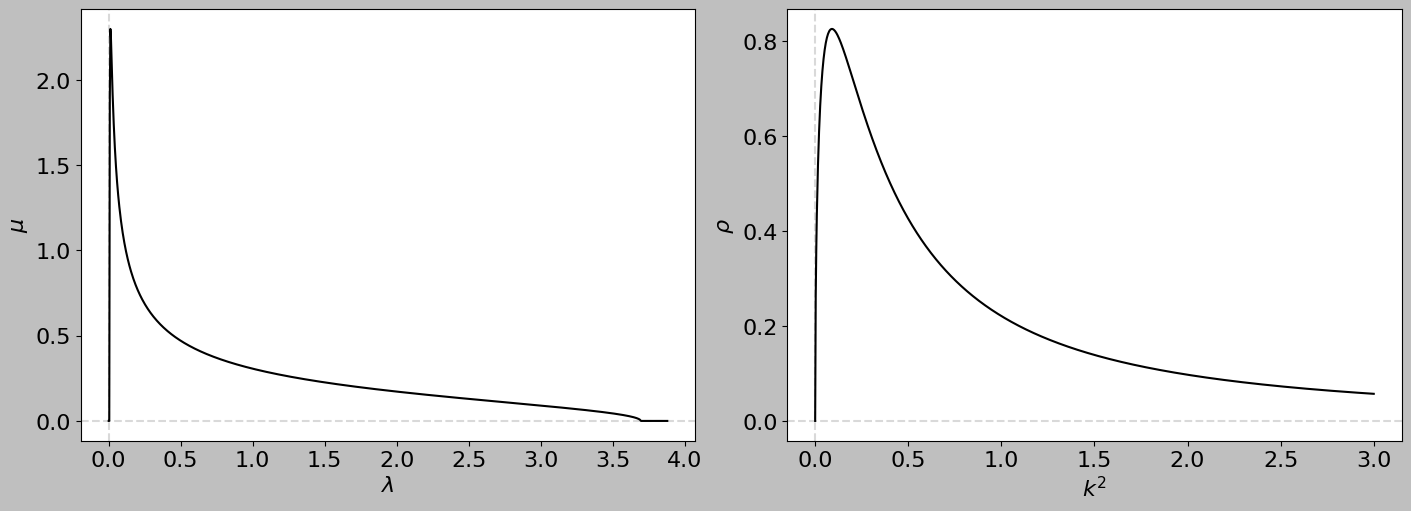

In [15]:
mp = MarchenkoPastur(ratio=0.85, sigma=1.0)
plot_distribution(mp)

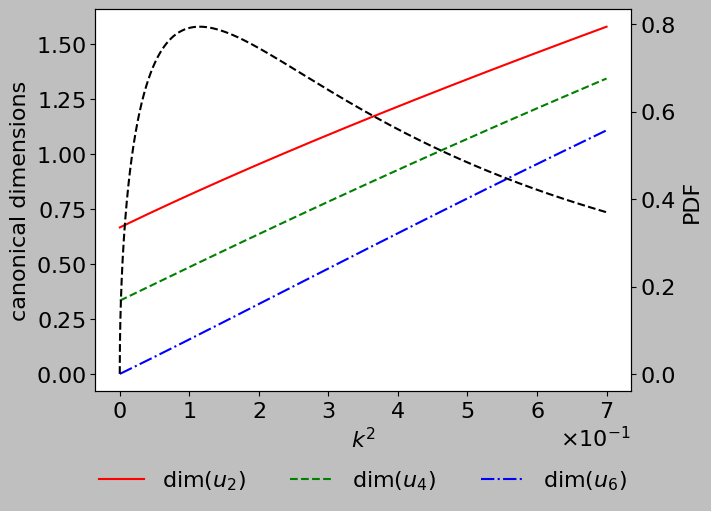

In [16]:
!../scripts/canonical_dimensions.py --config ../configs/config.yaml --analytic --suffix snr

with open(
    "results/mp_canonical_dimensions_analytic_sigma=1.0_ratio=0.5_seed=42.json"
) as f:
    data = json.load(f)
plot_canonical_dimensions(data, suffix="analytic", analytic=True)

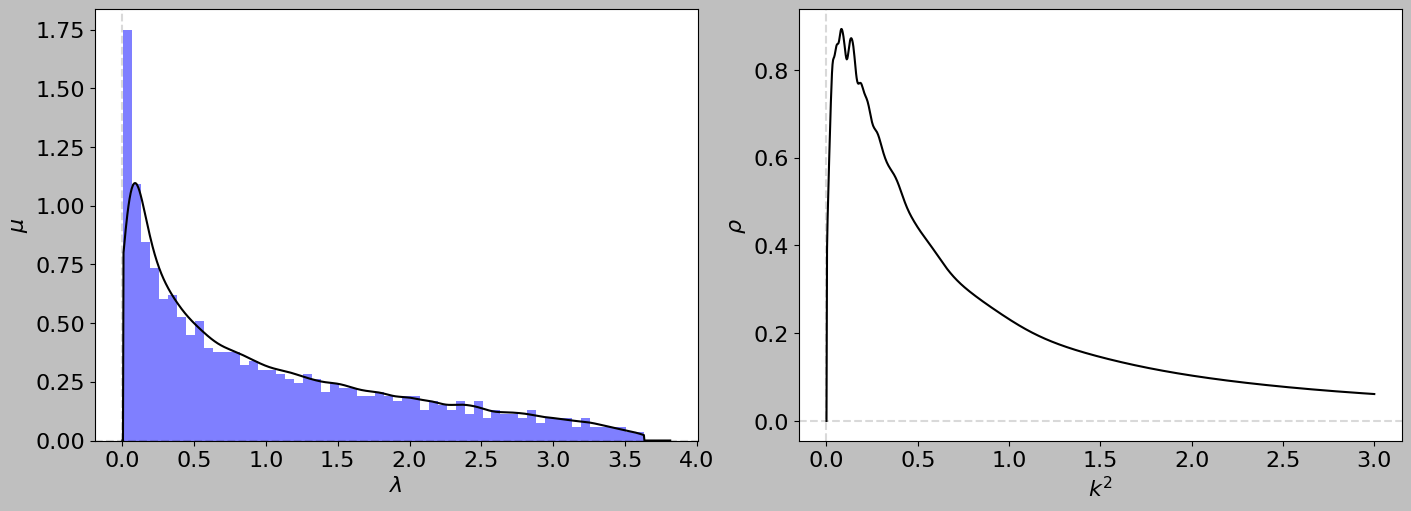

In [17]:
emp = EmpiricalDistribution(n_samples=1000, sigma=1.0, ratio=0.85)
emp = emp.fit()
plot_distribution(emp)

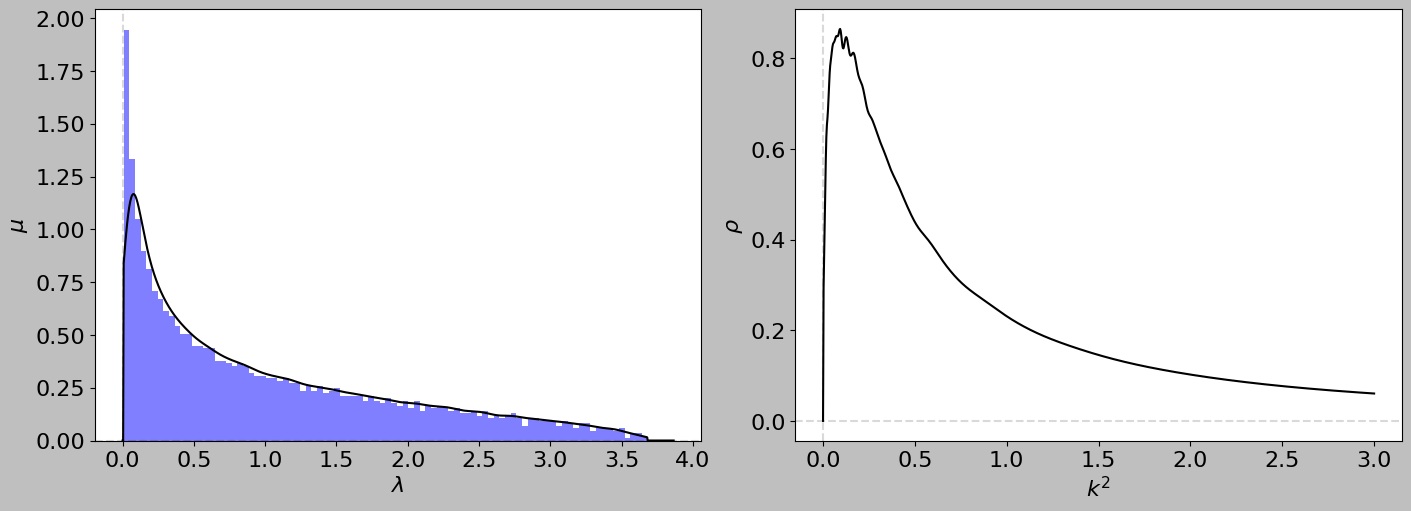

In [18]:
emp = EmpiricalDistribution(n_samples=2500, sigma=1.0, ratio=0.85)
emp = emp.fit()
plot_distribution(emp)

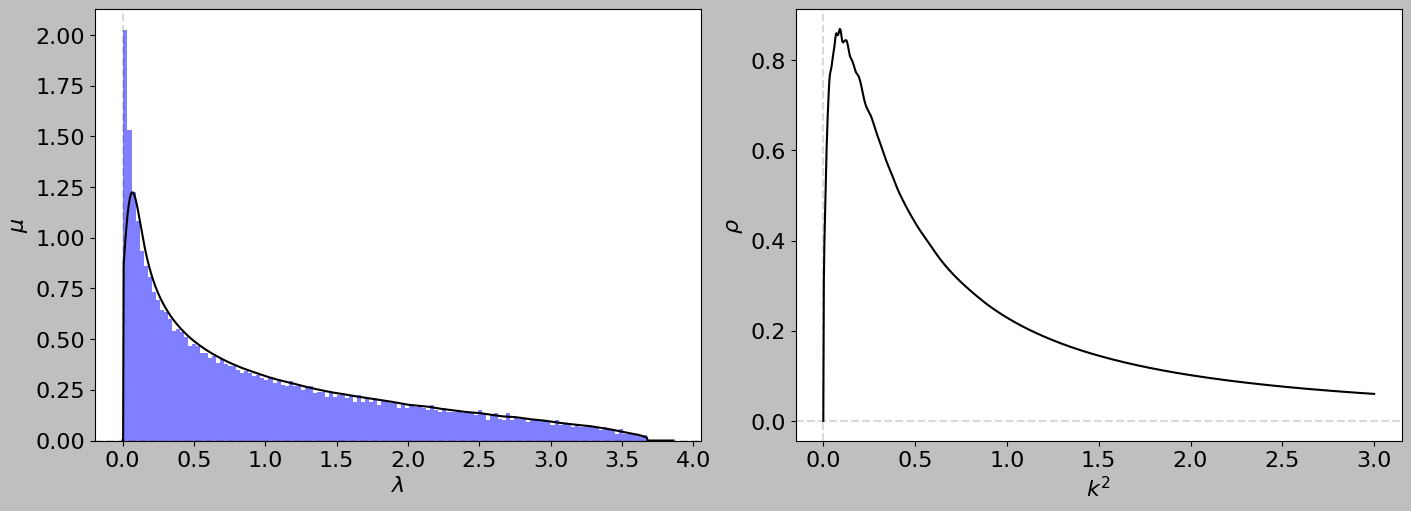

In [19]:
emp = EmpiricalDistribution(n_samples=5000, sigma=1.0, ratio=0.85)
emp = emp.fit()
plot_distribution(emp)

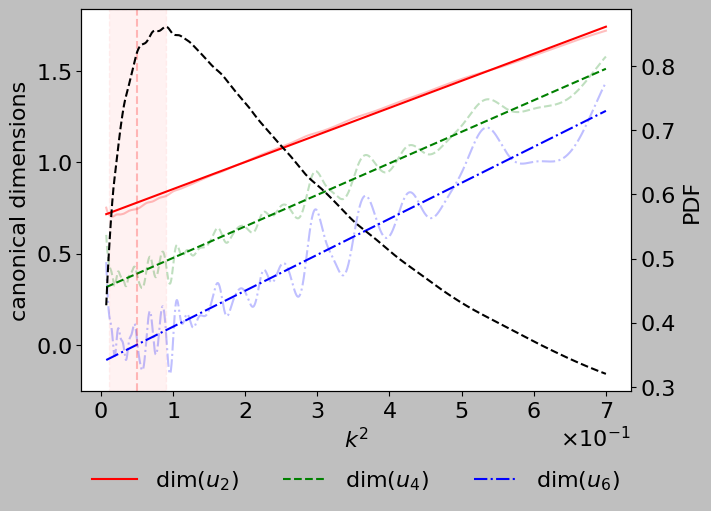

In [20]:
with open(
    "../results/canonical_dimensions_snr=0.0-0.5_img=gianduja/mp_canonical_dimensions_snr=0.0.json"
) as f:
    data = json.load(f)
plot_canonical_dimensions(data, suffix="snr=0.0_img=gianduja")

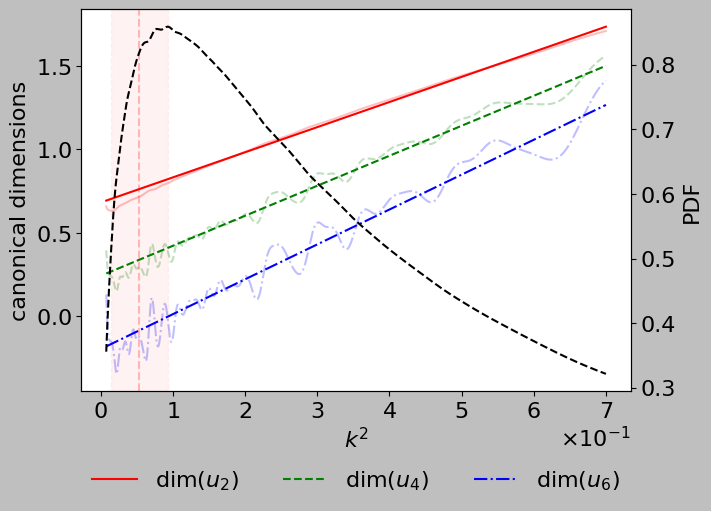

In [21]:
with open(
    "../results/canonical_dimensions_snr=0.0-0.5_img=gianduja/mp_canonical_dimensions_snr=0.2007007007007007.json"
) as f:
    data = json.load(f)
plot_canonical_dimensions(data, suffix="snr=0.20_img=gianduja")

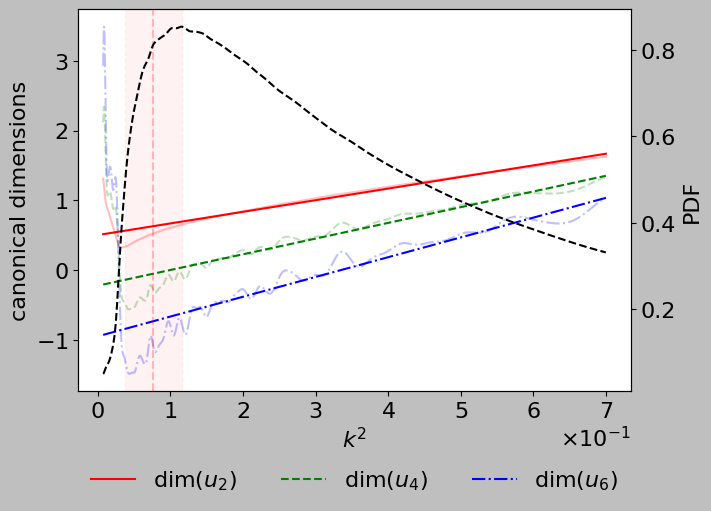

In [22]:
with open(
    "../results/canonical_dimensions_snr=0.0-0.5_img=gianduja/mp_canonical_dimensions_snr=0.4009009009009009.json"
) as f:
    data = json.load(f)
plot_canonical_dimensions(data, suffix="snr=0.40_img=gianduja")

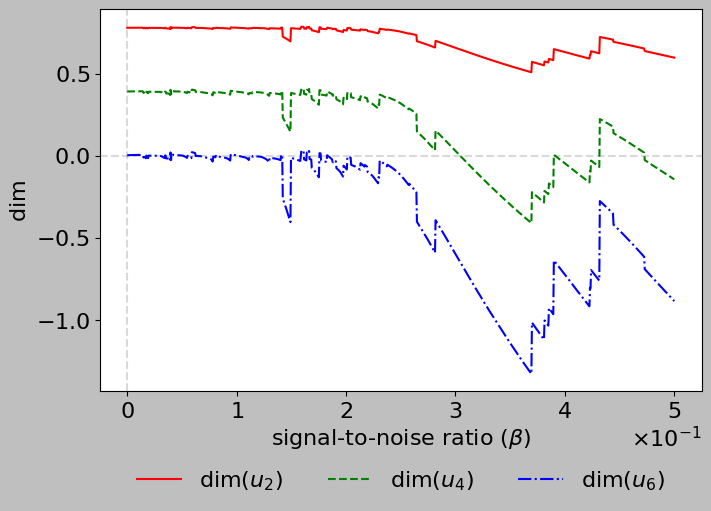

In [23]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-0.5_img=gianduja"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-0.5_img=gianduja",
)

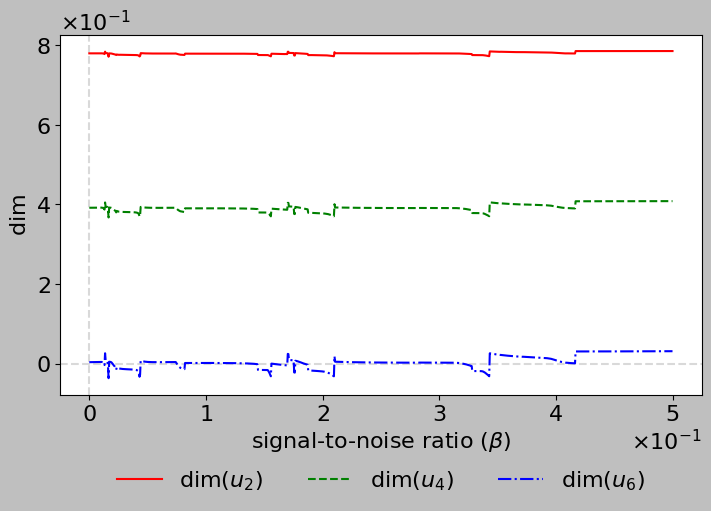

In [24]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-0.5_img=mnist1"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-0.5_img=mnist1",
)

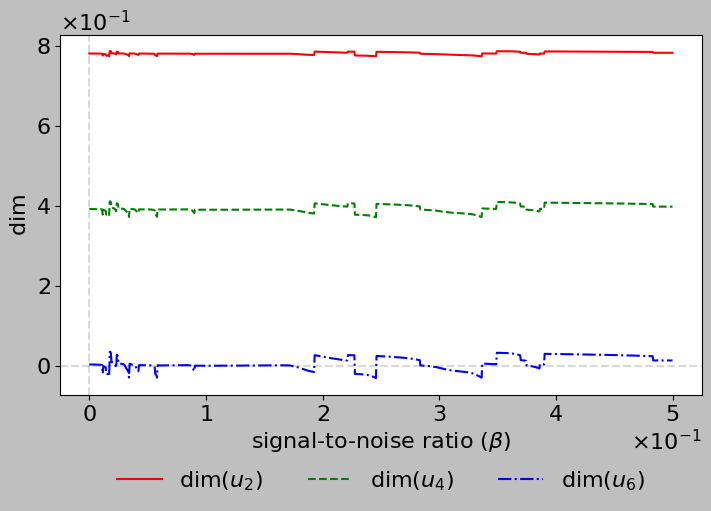

In [25]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-0.5_img=mnist2"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-0.5_img=mnist2",
)

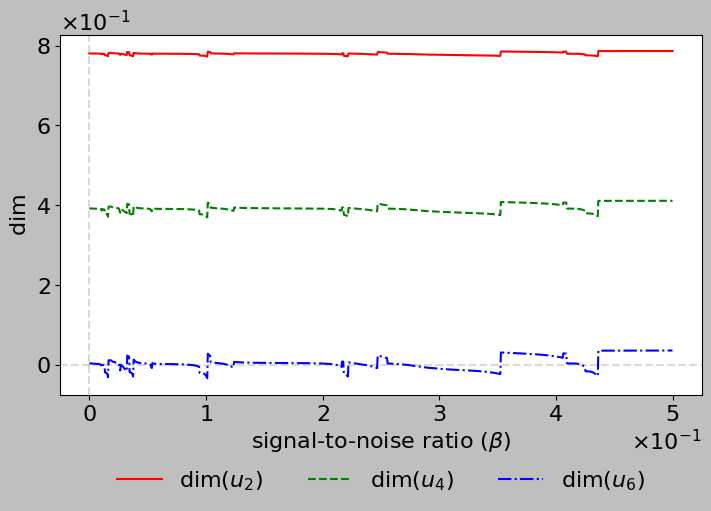

In [26]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-0.5_img=mnist3"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-0.5_img=mnist3",
)

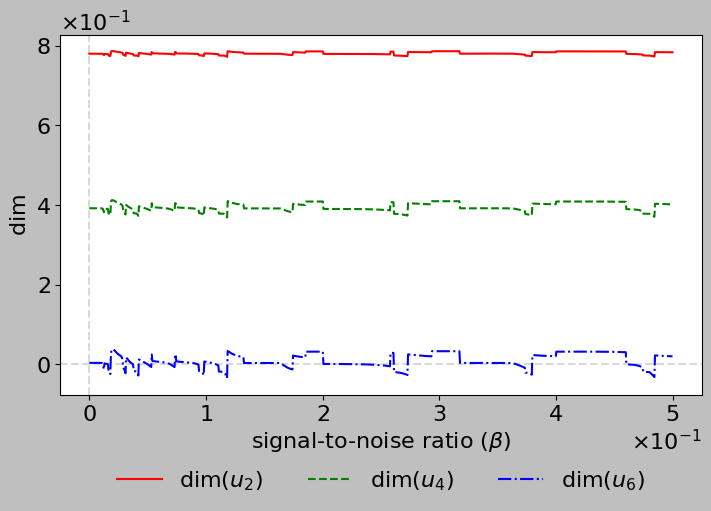

In [27]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-0.5_img=mnist4"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-0.5_img=mnist4",
)

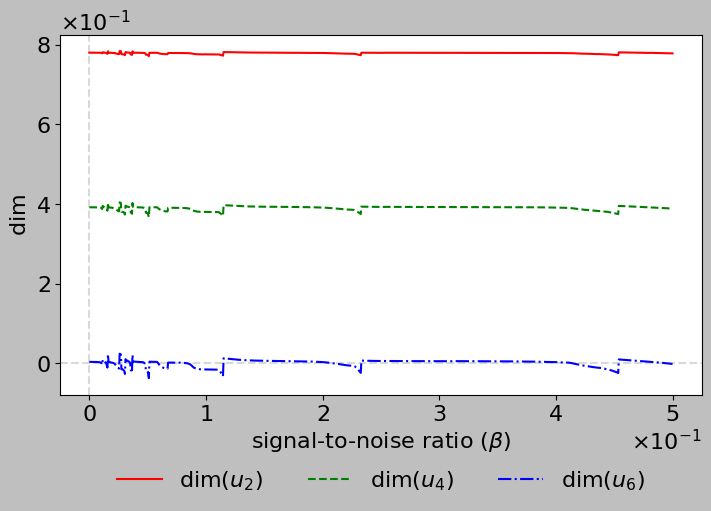

In [28]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-0.5_img=mnist5"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-0.5_img=mnist5",
)

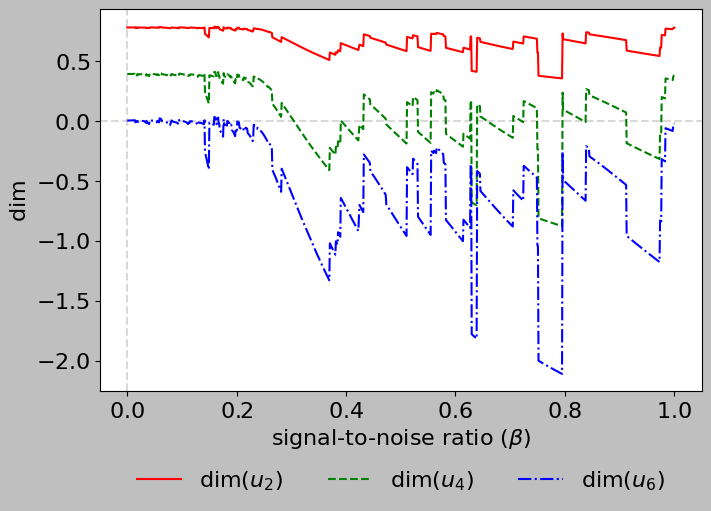

In [29]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-1.0_img=gianduja"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-1.0_img=gianduja",
)

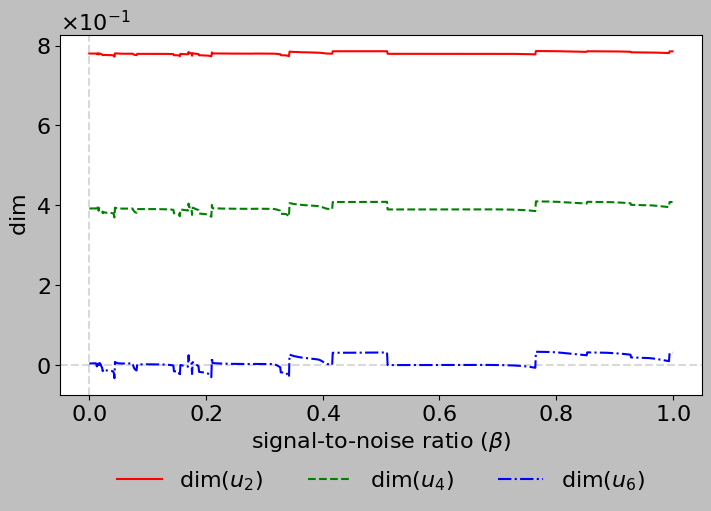

In [30]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-1.0_img=mnist1"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-1.0_img=mnist1",
)

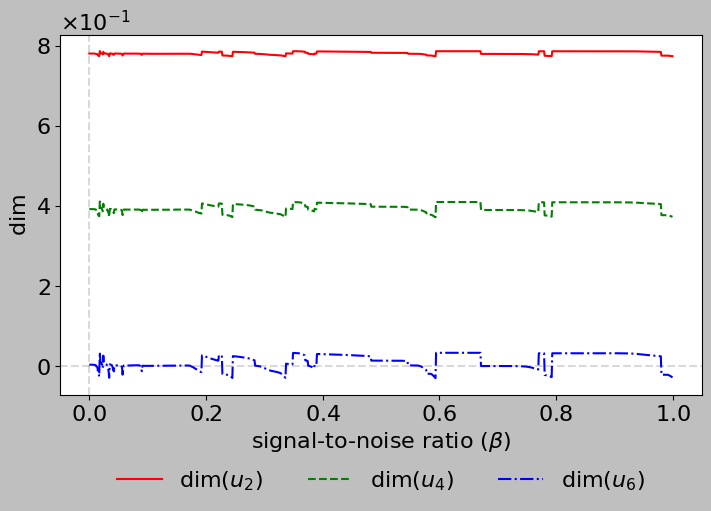

In [31]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-1.0_img=mnist2"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-1.0_img=mnist2",
)

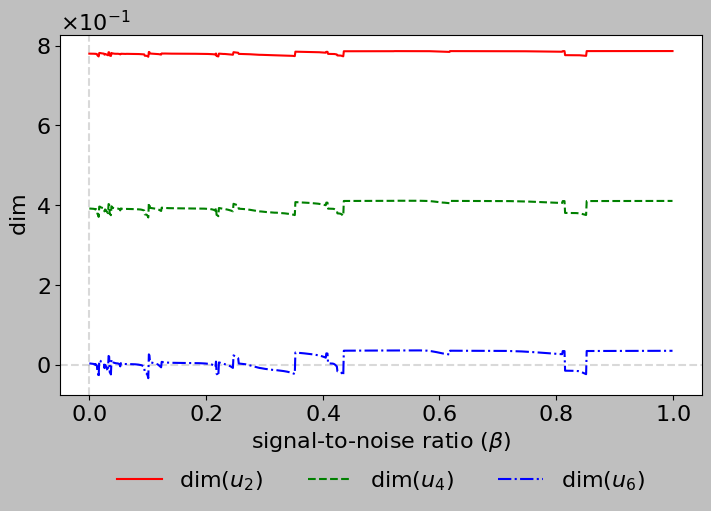

In [32]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-1.0_img=mnist3"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-1.0_img=mnist3",
)

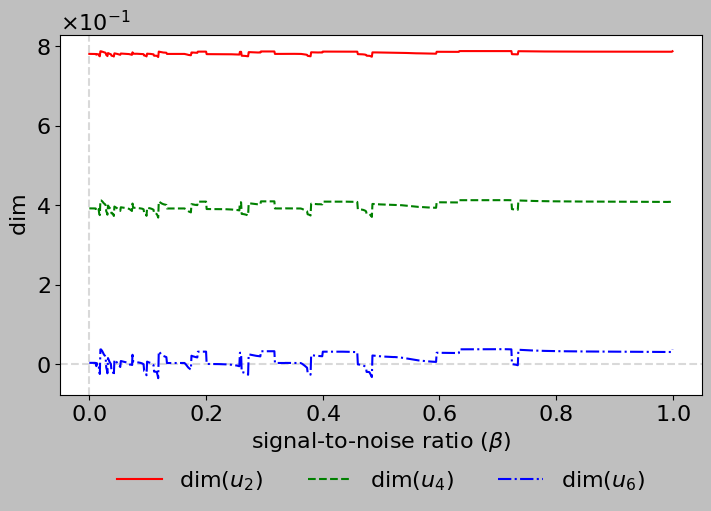

In [33]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-1.0_img=mnist4"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-1.0_img=mnist4",
)

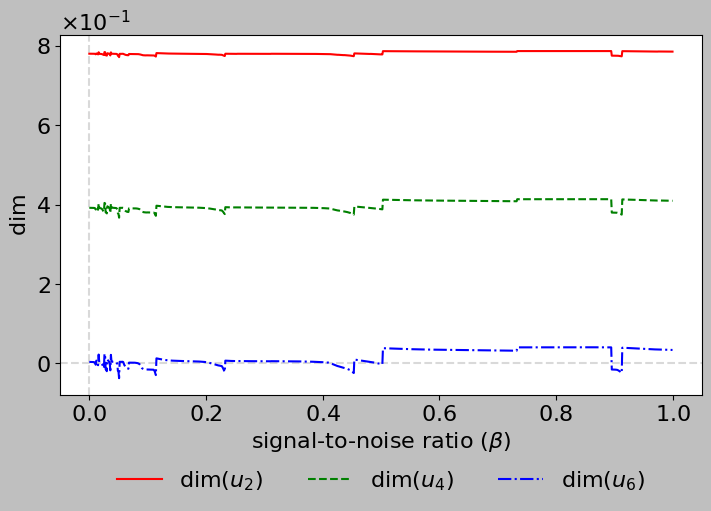

In [34]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-1.0_img=mnist5"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-1.0_img=mnist5",
)

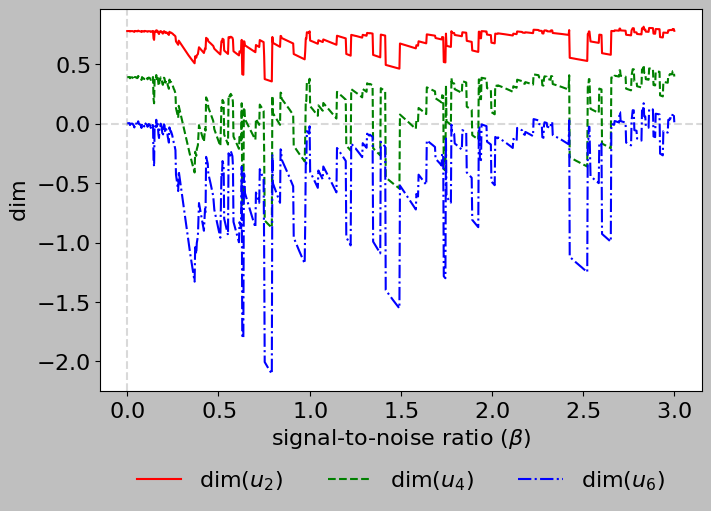

In [35]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-3.0_img=gianduja"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-3.0_img=gianduja",
)

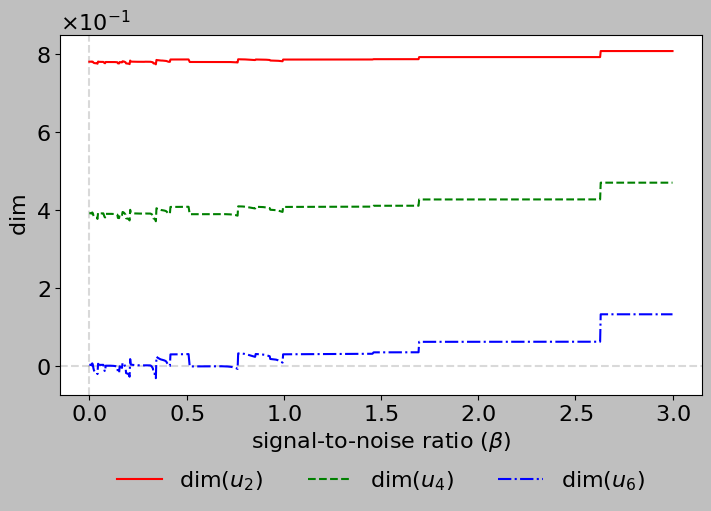

In [36]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-3.0_img=mnist1"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-3.0_img=mnist1",
)

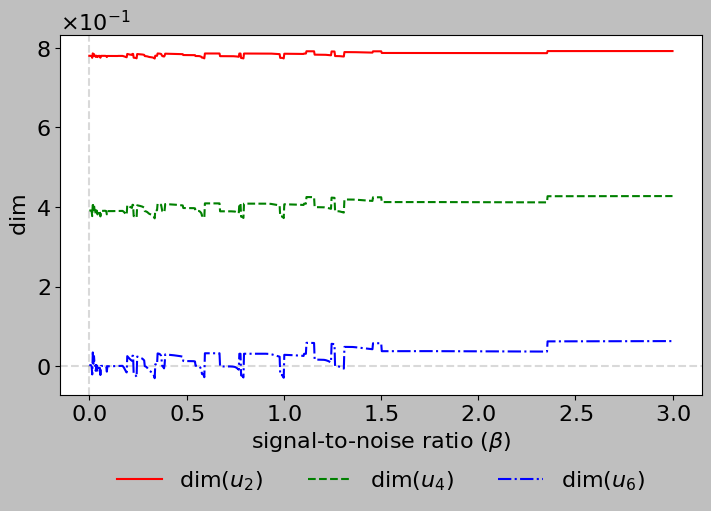

In [37]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-3.0_img=mnist2"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-3.0_img=mnist2",
)

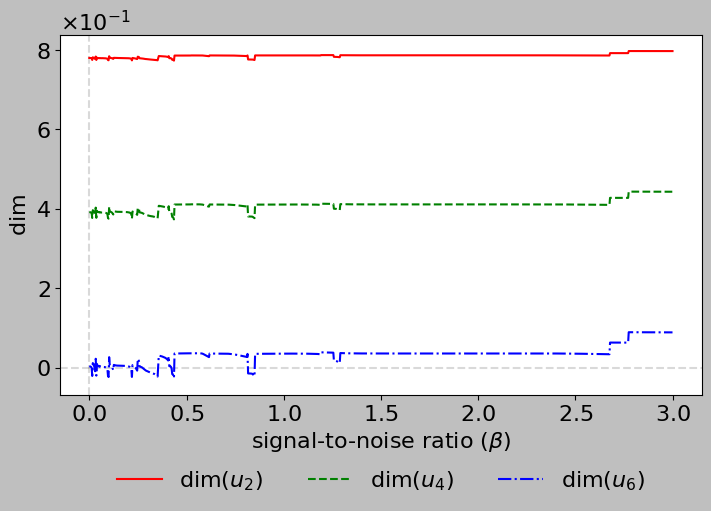

In [38]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-3.0_img=mnist3"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-3.0_img=mnist3",
)

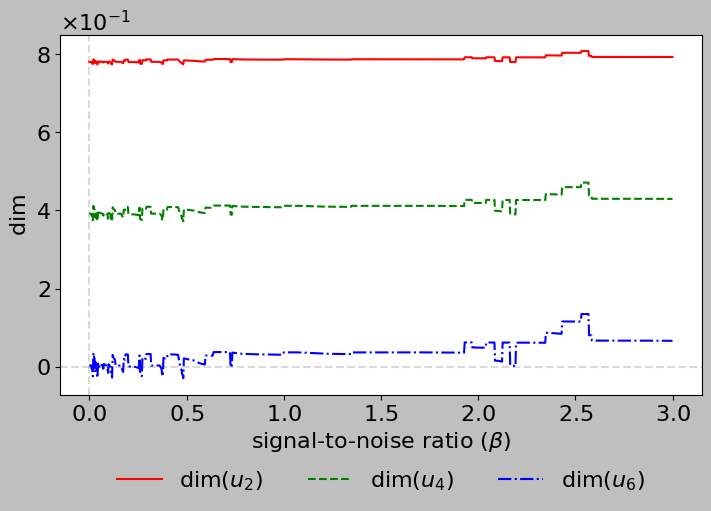

In [39]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-3.0_img=mnist4"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-3.0_img=mnist4",
)

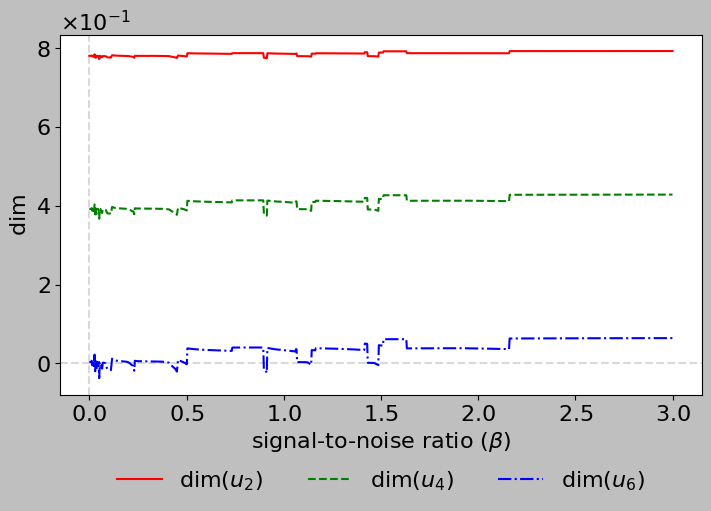

In [40]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-3.0_img=mnist5"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-3.0_img=mnist5",
)

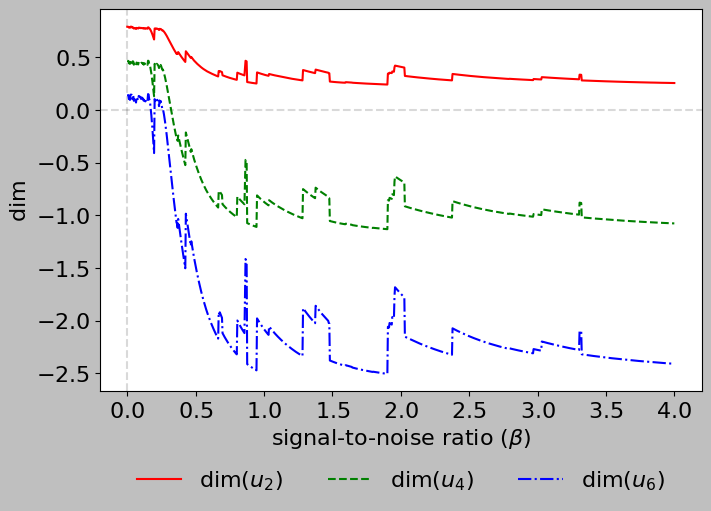

In [41]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-4.0_img=gianduja"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-4.0_img=gianduja",
)

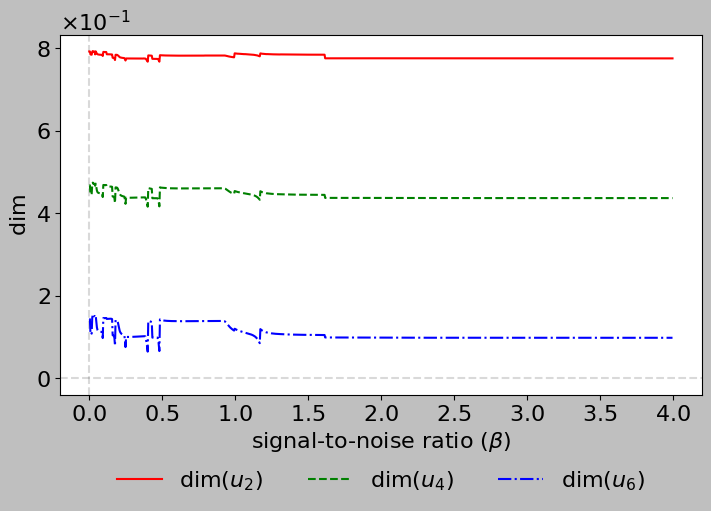

In [42]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-4.0_img=mnist1"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-4.0_img=mnist1",
)

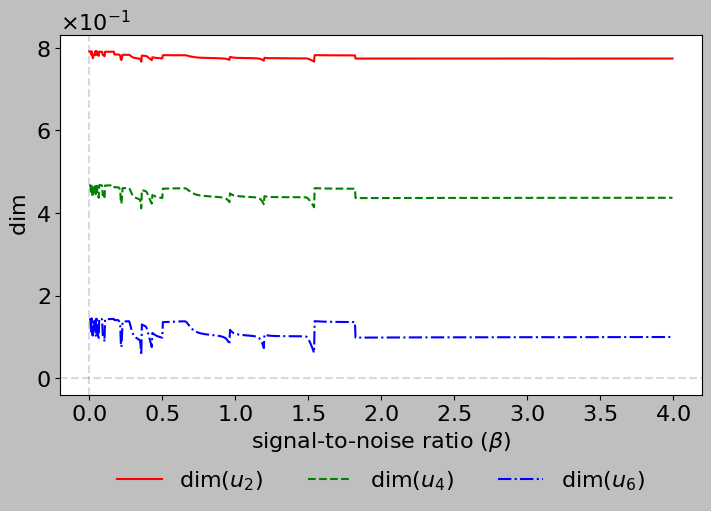

In [43]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-4.0_img=mnist2"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-4.0_img=mnist2",
)

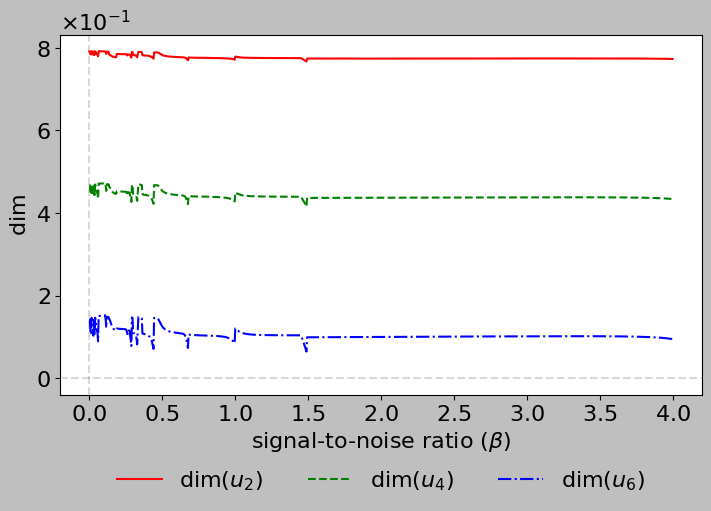

In [44]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-4.0_img=mnist3"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-4.0_img=mnist3",
)

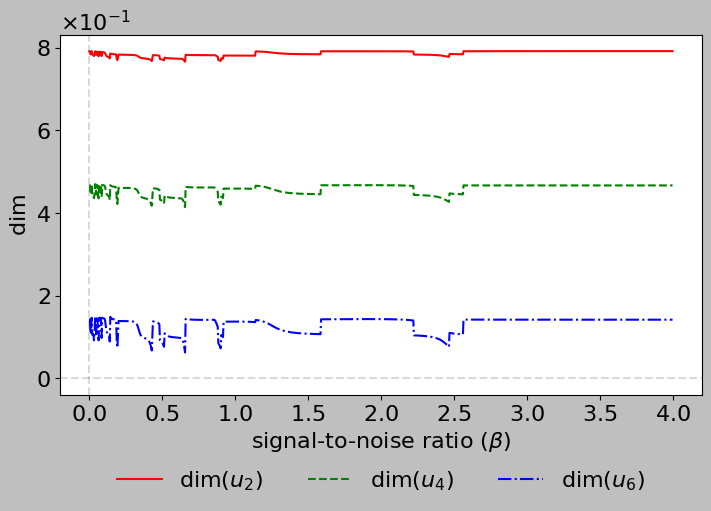

In [45]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-4.0_img=mnist4"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-4.0_img=mnist4",
)

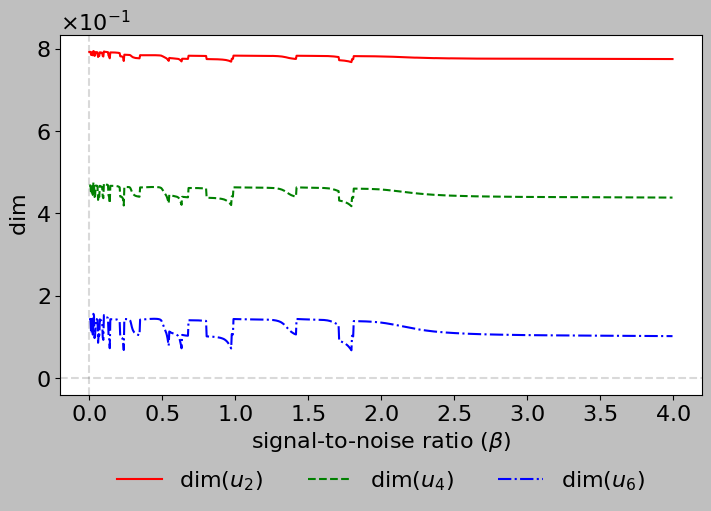

In [46]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_snr=0.0-4.0_img=mnist5"
)
plot_canonical_dimensions_scan(
    x,
    "signal-to-noise ratio ($\\beta$)",
    dimu2,
    dimu4,
    dimu6,
    "snr=0.0-4.0_img=mnist5",
)

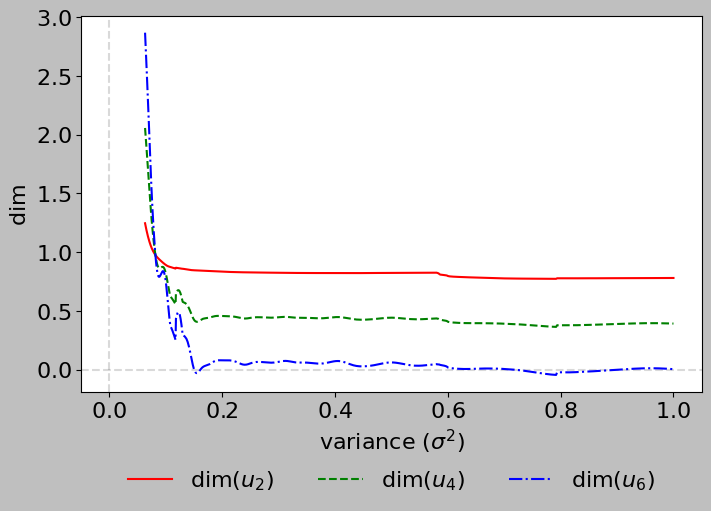

In [47]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_sigma=0.0-1.0"
)
plot_canonical_dimensions_scan(
    (x**2)[250:],
    "variance ($\\sigma^2$)",
    dimu2[250:],
    dimu4[250:],
    dimu6[250:],
    "sigma=0.0-1.0",
)

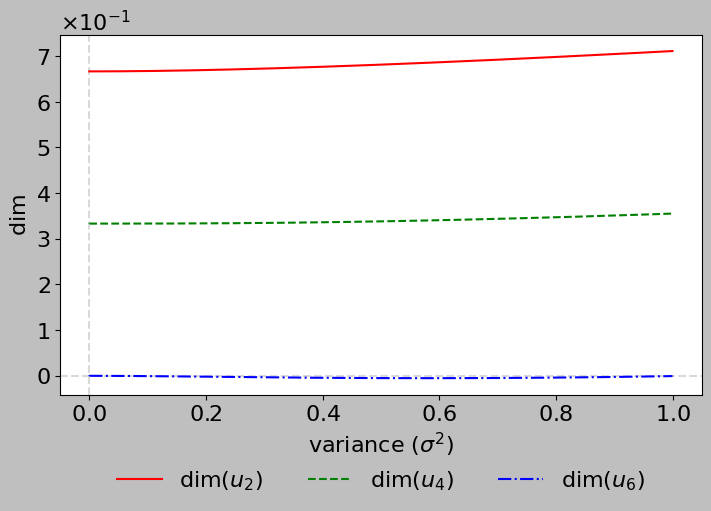

In [48]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_sigma=0.0-1.0_analytic", analytic=True
)
plot_canonical_dimensions_scan(
    x**2,
    "variance ($\\sigma^2$)",
    dimu2,
    dimu4,
    dimu6,
    "sigma=0.0-1.0_analytic",
)

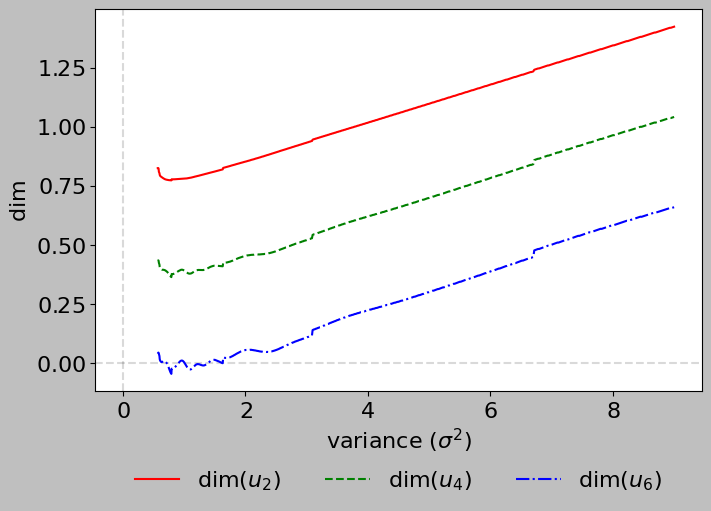

In [49]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_sigma=0.0-3.0"
)
plot_canonical_dimensions_scan(
    (x**2)[250:],
    "variance ($\\sigma^2$)",
    dimu2[250:],
    dimu4[250:],
    dimu6[250:],
    "sigma=0.0-3.0",
)

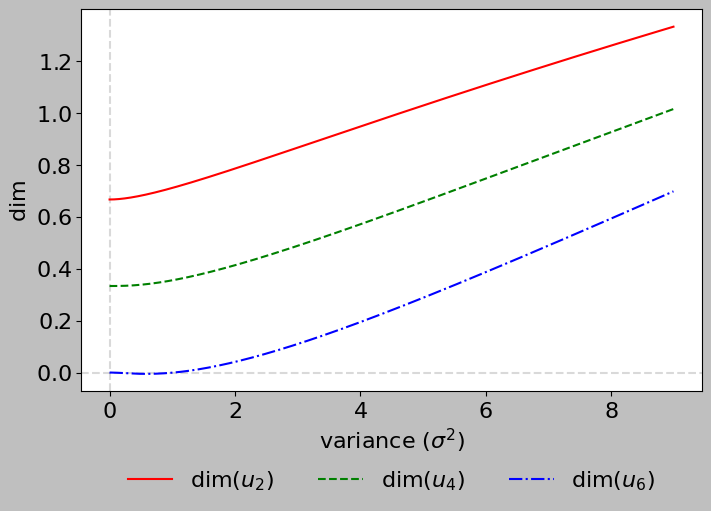

In [50]:
x, dimu2, dimu4, dimu6 = canonical_dimensions_files(
    "../results/canonical_dimensions_sigma=0.0-3.0_analytic", analytic=True
)
plot_canonical_dimensions_scan(
    x**2,
    "variance ($\\sigma^2$)",
    dimu2,
    dimu4,
    dimu6,
    "sigma=0.0-3.0_analytic",
)

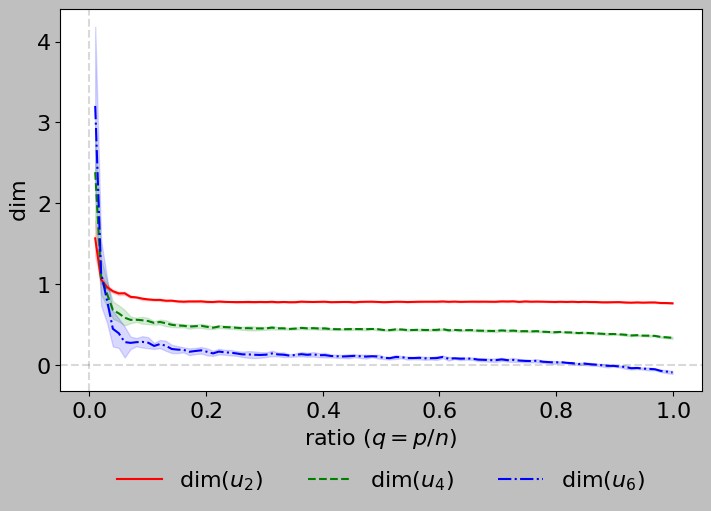

In [51]:
df = canonical_dimensions_ratio_files(
    "../results/canonical_dimensions_img=gianduja_ratio=0.0-1.0_snr=0.0"
)
groups = (
    df.groupby("ratio", group_keys=True)
    .agg(["mean", "std"])
    .drop(columns="seed")
)
plot_ratio_scan(groups, "snr=0.0")

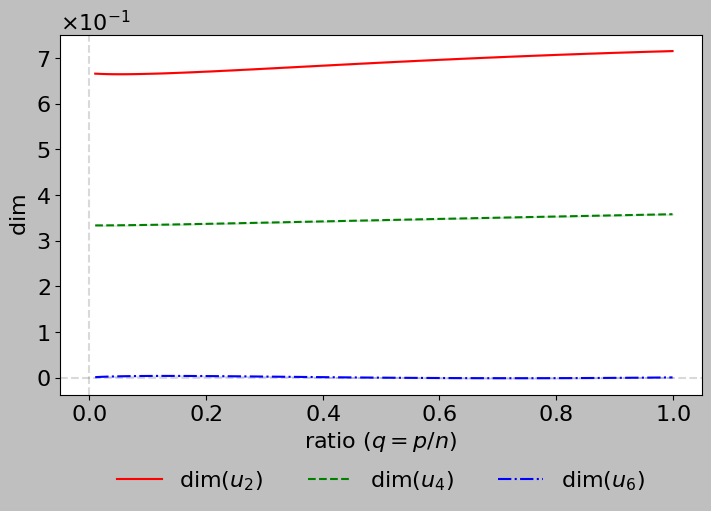

In [52]:
df = canonical_dimensions_ratio_files(
    "../results/canonical_dimensions_img=gianduja_ratio=0.0-1.0_snr=0.0_analytic",
    analytic=True,
)
groups = (
    df.groupby("ratio", group_keys=True)
    .agg(["mean", "std"])
    .drop(columns="seed")
)
plot_ratio_scan(groups, "snr=0.0_analytic")

In [53]:
df = canonical_dimensions_ratio_files(
    "../results/canonical_dimensions_img=gianduja_ratio=0.0-1.0_snr=1.25"
)
groups = (
    df.groupby("ratio", group_keys=True)
    .agg(["mean", "std"])
    .drop(columns="seed")
)
plot_ratio_scan(groups, "snr=1.25")

ValueError: attempt to get argmin of an empty sequence

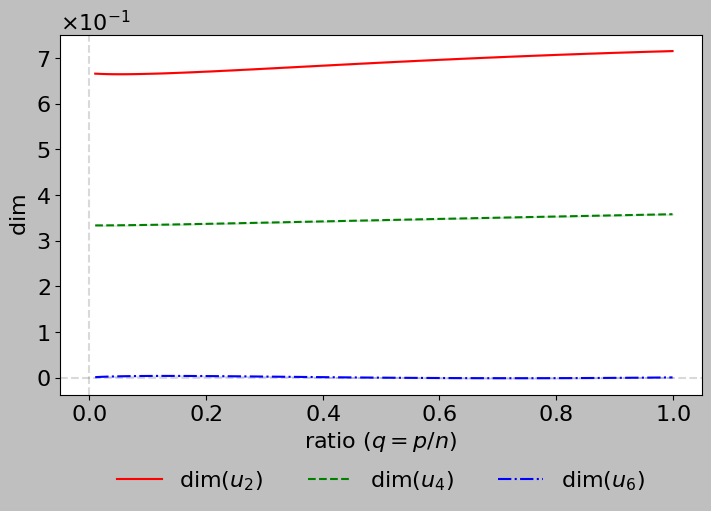

In [54]:
df = canonical_dimensions_ratio_files(
    "../results/canonical_dimensions_img=gianduja_ratio=0.0-1.0_snr=1.25_analytic",
    analytic=True,
)
groups = (
    df.groupby("ratio", group_keys=True)
    .agg(["mean", "std"])
    .drop(columns="seed")
)
plot_ratio_scan(groups, "snr=1.25_analytic")